In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200 # Make plots bigger
from matplotlib import colors
import numpy as np
import IPython.display as display

In [7]:
from numpy.fft import fft, ifft, fft2, ifft2, ifftshift, fftshift
def ft(x):
  return fftshift()

In [8]:
def colorbar(mappable, label = None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label: cbar.set_label(label)
    plt.sca(last_axes)
    return cbar

[0, 512, 0, 512]


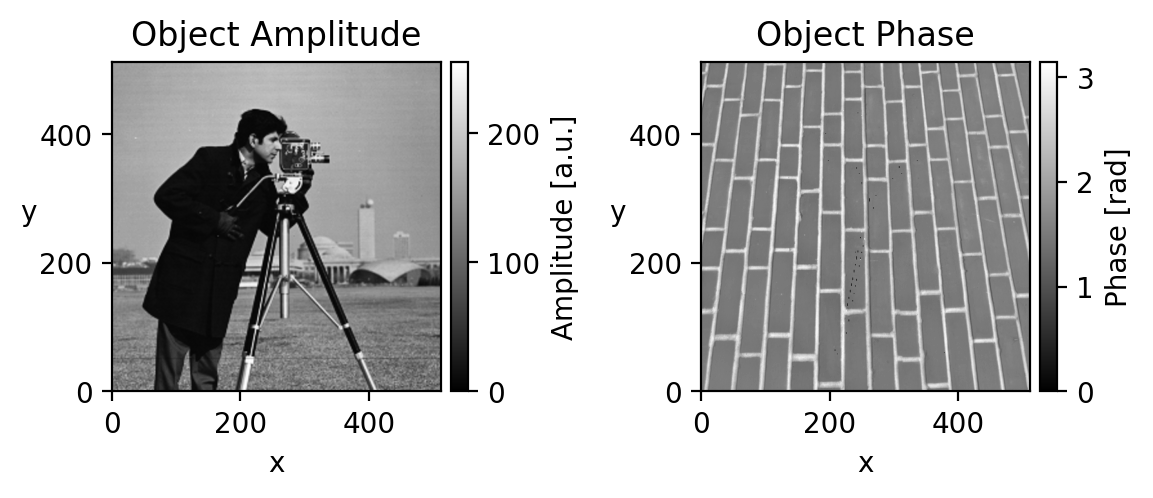

In [9]:
# Create test object
from skimage import data

objAmplitude = np.double(data.camera())
objPhase = np.double(data.brick())
objPhase = np.pi*objPhase/np.max(objPhase)
obj = objAmplitude*np.exp(1j*objPhase)

fig, ax = plt.subplots(1,2)

N, M = obj.shape
im_extent = [0, N, 0, M]
print(im_extent)
obj_him0 = ax[0].imshow(np.abs(obj), cmap = 'gray', extent = im_extent)
obj_him1 = ax[1].imshow(np.angle(obj), cmap = 'gray', extent = im_extent)

ax[0].set_title('Object Amplitude')
ax[1].set_title('Object Phase')

ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation = 0)

ax[1].set_xlabel('x')
ax[1].set_ylabel('y', rotation = 0)

colorbar(obj_him0, label = 'Amplitude [a.u.]')
colorbar(obj_him1, label = 'Phase [rad]')

plt.tight_layout()

In [10]:
# Specifications of the LED array
arraysize = 15                            
LEDpitch_mm = 4                          # Lateral distance between LEDs in the matrix (pitch)
LEDheight_mm = 90                         # Distance between LED matrix and the sample

# Generate x and y vectors for LED array
x = np.linspace(-(arraysize//2), arraysize//2, arraysize)*LEDpitch_mm
y = np.linspace(-(arraysize//2), arraysize//2, arraysize)*LEDpitch_mm
# Generate 2D array of ordered pairs for (x,y) coordinates of the LEDs
X, Y = np.meshgrid(x, y)

# Flatten the 2D arrays of (x,y) LED coordinates
xlocation = X.flatten()
print(xlocation)
ylocation = Y.flatten()

# Generate 1D array of kx and ky wavevectors corresponding to the LED index
kx_relative = -np.sin(np.arctan(xlocation/LEDheight_mm))
ky_relative = -np.sin(np.arctan(ylocation/LEDheight_mm))

[-28. -24. -20. -16. -12.  -8.  -4.   0.   4.   8.  12.  16.  20.  24.
  28. -28. -24. -20. -16. -12.  -8.  -4.   0.   4.   8.  12.  16.  20.
  24.  28. -28. -24. -20. -16. -12.  -8.  -4.   0.   4.   8.  12.  16.
  20.  24.  28. -28. -24. -20. -16. -12.  -8.  -4.   0.   4.   8.  12.
  16.  20.  24.  28. -28. -24. -20. -16. -12.  -8.  -4.   0.   4.   8.
  12.  16.  20.  24.  28. -28. -24. -20. -16. -12.  -8.  -4.   0.   4.
   8.  12.  16.  20.  24.  28. -28. -24. -20. -16. -12.  -8.  -4.   0.
   4.   8.  12.  16.  20.  24.  28. -28. -24. -20. -16. -12.  -8.  -4.
   0.   4.   8.  12.  16.  20.  24.  28. -28. -24. -20. -16. -12.  -8.
  -4.   0.   4.   8.  12.  16.  20.  24.  28. -28. -24. -20. -16. -12.
  -8.  -4.   0.   4.   8.  12.  16.  20.  24.  28. -28. -24. -20. -16.
 -12.  -8.  -4.   0.   4.   8.  12.  16.  20.  24.  28. -28. -24. -20.
 -16. -12.  -8.  -4.   0.   4.   8.  12.  16.  20.  24.  28. -28. -24.
 -20. -16. -12.  -8.  -4.   0.   4.   8.  12.  16.  20.  24.  28. -28.
 -24. 

In [38]:
# Setup the parameters for the imaging simulation
wavelength_m = 0.63e-6                              # Wavelength [m]
k0 = 2*np.pi/wavelength_m                           # Wavevector [1/m]
spsize = 2.75e-6                                    # Sampling pixel size of the CCD [m]
recon_ratio = 4                                     # Relative size between pixels in low resolution images and reconstructed image. Should be large enough to support the synthesized NA (NA_objective + NA_LED_max)
psize = spsize/recon_ratio                          # Pixel size of the reconstruction [m]
NA = 0.08                                           # Objective Numerical Aperture

# Generate the low-pass filtered images
[m, n] = obj.shape                                  # Shape of input images [pixel]
[m1, n1] = m // recon_ratio, n // recon_ratio       # Size of low resolution images [pixel]
imSeqLowRes = np.zeros([m1, n1, arraysize**2]) 
# Initialize array for low resolution images
kx, ky = k0 * kx_relative, k0 * ky_relative         # k-vector components for each LED [rad/m]
dkx, dky = 2*np.pi/(psize*n), 2*np.pi/(psize*m)     # Distance between spatial frequency samples [rad/m]
cutoffFrequency = NA * k0                           # Cutoff frequency [rad/m]
kmax = np.pi/spsize                                 # Maximum spatial frequency [rad/m]

kx_recon = np.linspace(-kmax, kmax, n1)
ky_recon = np.linspace(-kmax, kmax, m1)

kxm, kym = np.meshgrid(kx_recon, ky_recon)

CTF = ((kxm**2 + kym**2) < cutoffFrequency**2).astype(np.double)
objectFT = fftshift(fft2(obj))


debug = False

if debug:
  fig, ax = plt.subplots()
# Calculate kx,ky indices
for i in range(arraysize**2):
  kxc = np.int((n)/2 + kx[i]/dkx)
  kyc = np.int((m)/2 + ky[i]/dky)
  kyl = np.int(kyc - (m1)/2)
  kyh = np.int(kyc + (m1)/2)
  kxl = np.int(kxc - (n1)/2)
  kxh = np.int(kxc + (n1)/2)
  if debug:
    circ = plt.Circle((kxc, kyc), kxc-kxl, facecolor = 'none', edgecolor = 'k')
    ax.add_artist(circ)
    # print(f"kc = ({kxc},{kyc}). kx = ({kxl},{kxh}). ky = ({kyl},{kyh})")
  imSeqLowFT = (recon_ratio)**2 * objectFT[kyl:kyh, kxl:kxh] * CTF

  imSeqLowRes[:,:,i] = np.abs(ifft2(ifftshift(imSeqLowFT)))

if debug:
  ax.set_xlim([0,500])
  ax.set_ylim([0,500])
  ax.set_aspect(1)
  plt.show()

(kx,ky) = 1745.66,-0.00 mm


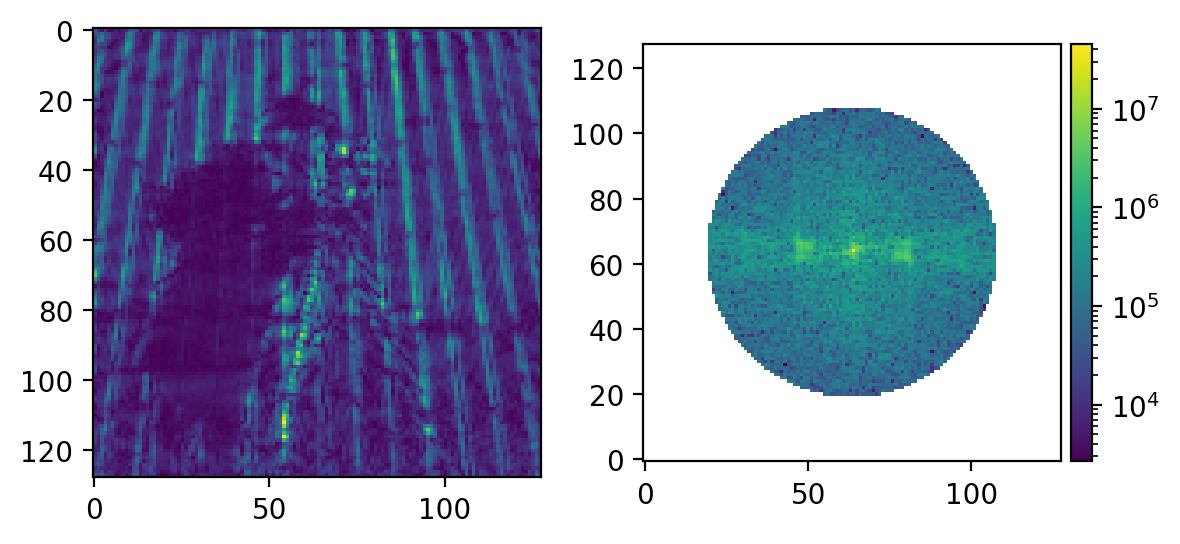

In [32]:
i = 108

print(f"(kx,ky) = {kx[i]*1e-3:0.2f},{ky[i]*1e-3:0.2f} mm")
fig, ax = plt.subplots(1,2)
him = ax[0].imshow(imSeqLowRes[:,:,i])

him = ax[1].imshow(np.abs(fftshift(fft2(imSeqLowRes[:,:,i])) * CTF), norm=colors.LogNorm(), origin = "lower")
colorbar(him)

plt.tight_layout()

In [13]:
def gseq(arraysize):
  n = (arraysize-1)/2
  sequence = np.zeros([2, arraysize**2])
  sequence[0,0] = n; sequence[1,0] = n
  dx = 1; dy = -1; stepx = 1; stepy = -1;
  direction = 1; counter = 0;

  for i in range(1,arraysize**2):
    counter += 1
    if (direction == 1):
      sequence[0,i] = sequence[0,i-1] + dx
      sequence[1,i] = sequence[1,i-1]
      if (counter == np.abs(stepx)):
        counter = 0; direction *= -1;
        dx *= -1; stepx *= -1;
        if stepx > 0:
          stepx += 1
        else:
          stepx -= 1
    else:
      sequence[0,i] = sequence[0,i-1]
      sequence[1,i] = sequence[1,i-1] + dy
      if (counter == np.abs(stepy)):
        counter = 0; direction *= -1;
        dy *= -1; stepy *= -1;
        if stepy > 0:
          stepy += 1
        else:
          stepy -= 1

  seq = (sequence[0,:]) * arraysize + sequence[1,:]
  return seq.astype(np.int)

[112 127 126 111  96  97  98 113 128 143 142 141 140 125 110  95  80  81
  82  83  84  99 114 129 144 159 158 157 156 155 154 139 124 109  94  79
  64  65  66  67  68  69  70  85 100 115 130 145 160 175 174 173 172 171
 170 169 168 153 138 123 108  93  78  63  48  49  50  51  52  53  54  55
  56  71  86 101 116 131 146 161 176 191 190 189 188 187 186 185 184 183
 182 167 152 137 122 107  92  77  62  47  32  33  34  35  36  37  38  39
  40  41  42  57  72  87 102 117 132 147 162 177 192 207 206 205 204 203
 202 201 200 199 198 197 196 181 166 151 136 121 106  91  76  61  46  31
  16  17  18  19  20  21  22  23  24  25  26  27  28  43  58  73  88 103
 118 133 148 163 178 193 208 223 222 221 220 219 218 217 216 215 214 213
 212 211 210 195 180 165 150 135 120 105  90  75  60  45  30  15   0   1
   2   3   4   5   6   7   8   9  10  11  12  13  14  29  44  59  74  89
 104 119 134 149 164 179 194 209 224]


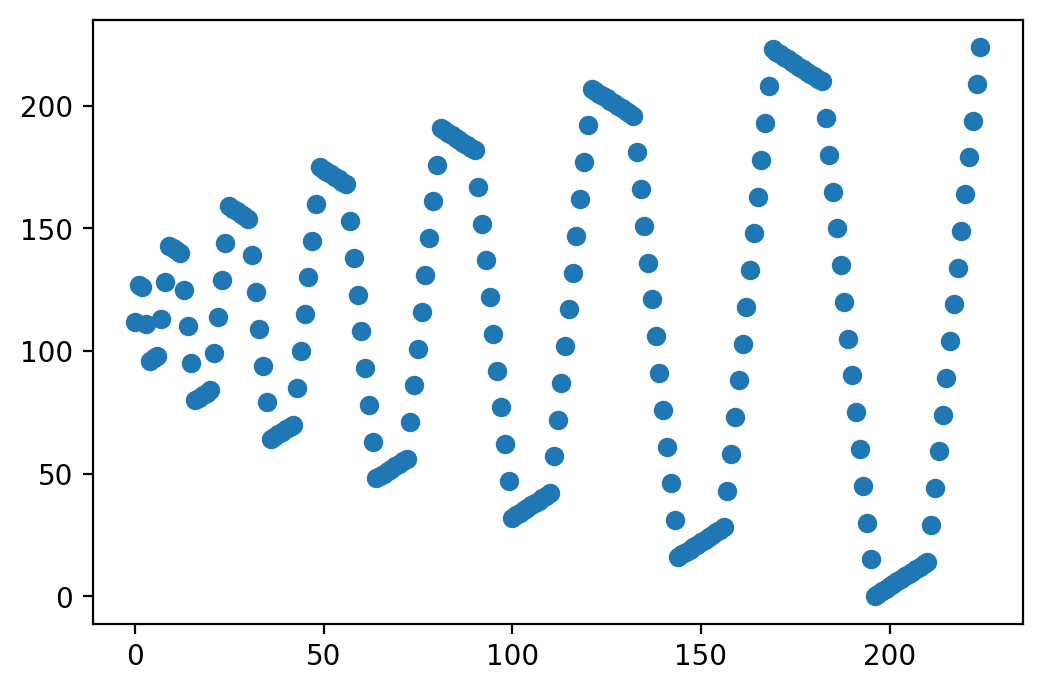

In [14]:
# Debugging sequence
seq = gseq(arraysize)
print(seq)
plt.plot(seq, 'o')

Loop 5.


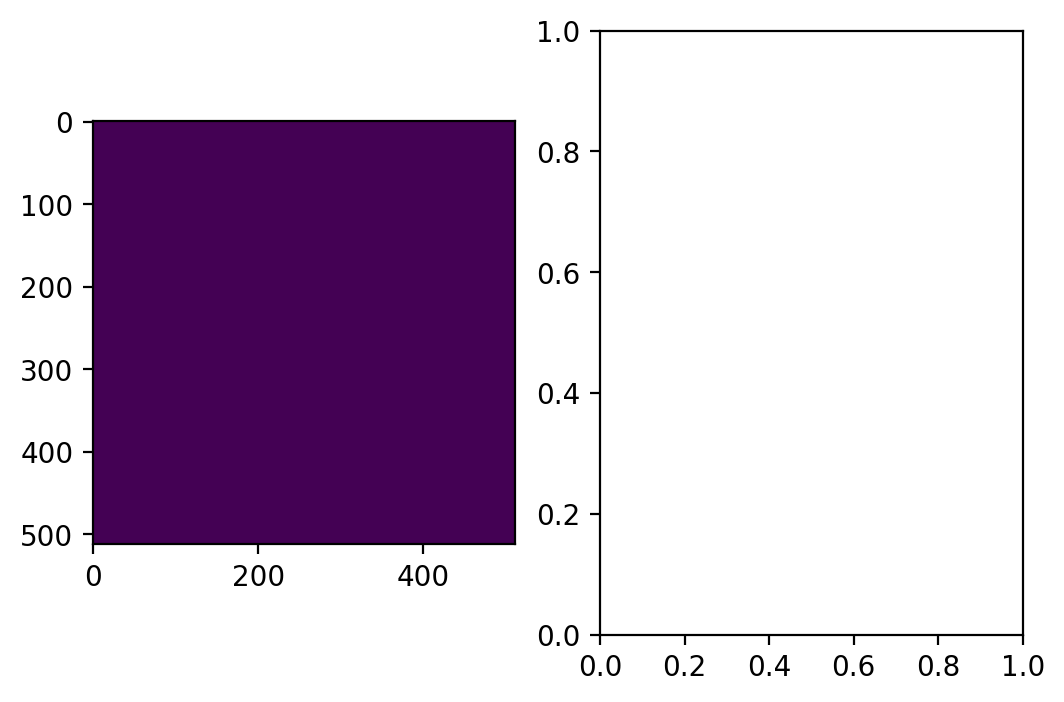

In [41]:
# Reconstruction code
seq = gseq(arraysize)

objectRecover = np.ones([m, n])
fig, ax = plt.subplots(1,2)
him = ax[0].imshow(objectRecover)
objectRecoverFT = fftshift(fft2(objectRecover))

debug = True

num_loop = 5

for i in range(num_loop):
  display.clear_output()
  if debug: print(f"Loop {i+1}.")
  for j in range(arraysize**2):
    k = seq[j]
    kxc = np.round(n/2+kx[k]/dkx)
    kyc = np.round(m/2+ky[k]/dky)
    kyl = np.round((kyc - m1/2)).astype(np.int); kyh = np.round((kyc + m1/2)).astype(np.int);
    kxl = np.round((kxc - n1/2)).astype(np.int); kxh = np.round((kxc + n1/2)).astype(np.int);
    lowResFT = (recon_ratio)**2 * objectRecoverFT[kyl:kyh, kxl:kxh] * CTF
    im_lowRes = ifft2(ifftshift(lowResFT))
    im_lowRes = 1/((recon_ratio)**2) * imSeqLowRes[:,:,k] * np.exp(1j*np.angle(im_lowRes))
    lowResFT = fftshift(fft2(im_lowRes)) * CTF
    objectRecoverFT[kyl:kyh, kxl:kxh] = (1-CTF) * objectRecoverFT[kyl:kyh, kxl:kxh] + lowResFT

objectRecover = ifft2(ifftshift(objectRecoverFT))

0.0


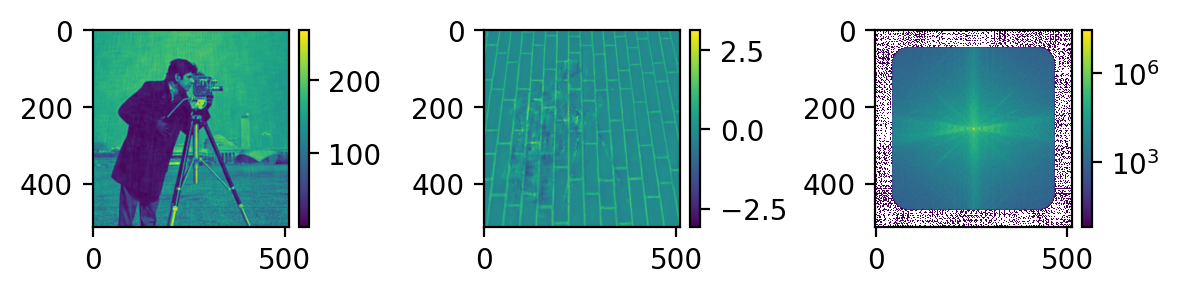

In [20]:
fig, ax = plt.subplots(1, 3)


him0 = ax[0].imshow(np.abs(objectRecover))
him1 = ax[1].imshow(np.angle(objectRecover))
him2 = ax[2].imshow(np.abs(objectRecoverFT), norm = colors.LogNorm())

print(np.abs(objectRecoverFT[2,10]))

colorbar(him0); colorbar(him1); colorbar(him2)

plt.tight_layout()